The following tutorials are available from the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2026.1_tutorials/wallaroo-model-operations-tutorials/deploy/by-use-case/notebooks-in-prod).

# Stage 2: Training Process Automation Setup
 
Now that we have decided on the type and structure of the model from Stage 1: Data Exploration And Model Selection, this notebook modularizes the various steps of the process in a structure that is compatible with production and with Wallaroo.

We have pulled the preprocessing and postprocessing steps out of the training notebook into individual scripts that can also be used when the model is deployed.

Assuming no changes are made to the structure of the model, this notebook, or a script based on this notebook, can then be scheduled to run on a regular basis, to refresh the model with more recent training data. We'd expect to run this notebook in conjunction with the Stage 3 notebook, `03_deploy_model.ipynb`.  For clarity in this demo, we have split the training/upload task into two notebooks, `02_automated_training_process.ipynb` and `03_deploy_model.ipynb`.

## Resources

The following resources are used as part of this tutorial:

* **data**
  * `data/seattle_housing_col_description.txt`: Describes the columns used as part data analysis.
  * `data/seattle_housing.csv`: Sample data of the Seattle, Washington housing market between 2014 and 2015.
* **code**
  * `postprocess.py`: Formats the data after inference by the model is complete.
  * `preprocess.py`: Formats the incoming data for the model.
  * `simdb.py`: A simulated database to demonstrate sending and receiving queries.
  * `wallaroo_client.py`: Additional methods used with the Wallaroo instance to create workspaces, etc.

## Steps

The following steps are part of this process:

* [Retrieve Training Data](#retrieve-training-data): Connect to the data store and retrieve the training data.
* [Data Transformations](#data-transformations): Evaluate the data and train the model.
* [Generate and Test the Model](#generate-and-test-the-model): Create the model and verify it against the sample test data.
* [Pickle The Model](#pickle-the-model): Prepare the model to be uploaded to Wallaroo.

### Retrieve Training Data

Note that this connection is simulated to demonstrate how data would be retrieved from an existing data store.  For training, we will use the data on all houses sold in this market with the last two years.

In [1]:
import numpy as np
import pandas as pd

import sklearn

import xgboost as xgb

import seaborn
import matplotlib
import matplotlib.pyplot as plt

import pickle

import simdb # module for the purpose of this demo to simulate pulling data from a database

from preprocess import create_features  # our custom preprocessing
from postprocess import postprocess    # our custom postprocessing

matplotlib.rcParams["figure.figsize"] = (12,6)

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = simdb.simulate_db_connection()
tablename = simdb.tablename

query = f"select * from {tablename} where date > DATE(DATE(), '-24 month') AND sale_price is not NULL"
print(query)
# read in the data
housing_data = pd.read_sql_query(query, conn)

conn.close()
housing_data.loc[:, ["id", "date", "list_price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot"]]

select * from house_listings where date > DATE(DATE(), '-24 month') AND sale_price is not NULL


,id,date,list_price,bedrooms,bathrooms,sqft_living,sqft_lot
0,7129300520,2023-07-31,221900.0,3,1.00,1180,5650
1,6414100192,2023-09-26,538000.0,3,2.25,2570,7242
2,5631500400,2023-12-13,180000.0,2,1.00,770,10000
3,2487200875,2023-09-26,604000.0,4,3.00,1960,5000
4,1954400510,2023-12-06,510000.0,3,2.00,1680,8080
...,...,...,...,...,...,...,...
20518,263000018,2023-03-08,360000.0,3,2.50,1530,1131
20519,6600060120,2023-12-11,400000.0,4,2.50,2310,5813
20520,1523300141,2023-04-10,402101.0,2,0.75,1020,1350
20521,291310100,2023-11-03,400000.0,3,2.50,1600,2388


### Data transformations

To improve relative error performance, we will predict on `log10` of the sale price.

Predict on log10 price to try to improve relative error performance

In [3]:
housing_data['logprice'] = np.log10(housing_data.list_price)

In [4]:
# split data into training and test
outcome = 'logprice'

runif = np.random.default_rng(2206222).uniform(0, 1, housing_data.shape[0])
gp = np.where(runif < 0.2, 'test', 'training')

hd_train = housing_data.loc[gp=='training', :].reset_index(drop=True, inplace=False)
hd_test = housing_data.loc[gp=='test', :].reset_index(drop=True, inplace=False)

# split the training into training and val for xgboost
runif = np.random.default_rng(123).uniform(0, 1, hd_train.shape[0])
xgb_gp = np.where(runif < 0.2, 'val', 'train')

In [5]:
# for xgboost
train_features = hd_train.loc[xgb_gp=='train', :].reset_index(drop=True, inplace=False)
train_features = np.array(create_features(train_features))
train_labels = np.array(hd_train.loc[xgb_gp=='train', outcome])

val_features = hd_train.loc[xgb_gp=='val', :].reset_index(drop=True, inplace=False)
val_features = np.array(create_features(val_features))
val_labels = np.array(hd_train.loc[xgb_gp=='val', outcome])

print(f'train_features: {train_features.shape}, train_labels: {len(train_labels)}')
print(f'val_features: {val_features.shape}, val_labels: {len(val_labels)}')


train_features: (13129, 18), train_labels: 13129
val_features: (3300, 18), val_labels: 3300


### Generate and Test the Model

Based on the experimentation and testing performed in **Stage 1: Data Exploration And Model Selection**, XGBoost was selected as the ML model and the variables for training were selected.  The model will be generated and tested against sample data.

In [6]:

xgb_model = xgb.XGBRegressor(
    objective = 'reg:squarederror', 
    max_depth=5, 
    base_score = np.mean(hd_train[outcome])
    )

xgb_model.fit( 
    train_features,
    train_labels,
    eval_set=[(train_features, train_labels), (val_features, val_labels)],
    verbose=False,
    early_stopping_rounds=35
)


XGBRegressor(base_score=5.666446833601829, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
print(xgb_model.best_score)
print(xgb_model.best_iteration)
print(xgb_model.best_ntree_limit)

0.07793614689092423
99
100


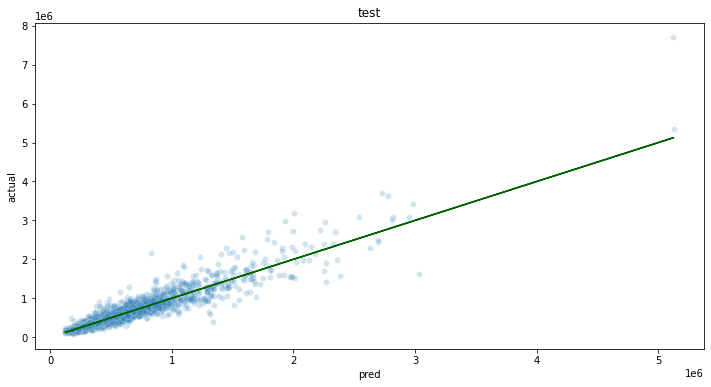

In [8]:
test_features = np.array(create_features(hd_test.copy()))
test_labels = np.array(hd_test.loc[:, outcome])

pframe = pd.DataFrame({
    'pred' : postprocess(xgb_model.predict(test_features)),
    'actual' : postprocess(test_labels)
})

ax = seaborn.scatterplot(
    data=pframe,
    x='pred',
    y='actual',
    alpha=0.2
)
matplotlib.pyplot.plot(pframe.pred, pframe.pred, color='DarkGreen')
matplotlib.pyplot.title("test")
plt.show()

In [9]:
pframe['se'] = (pframe.pred - pframe.actual)**2

pframe['pct_err'] = 100*np.abs(pframe.pred - pframe.actual)/pframe.actual
pframe.describe()

,pred,actual,se,pct_err
count,4.094000e+03,4.094000e+03,4.094000e+03,4094.000000
mean,5.340824e+05,5.396937e+05,1.657722e+10,12.857674
std,3.413714e+05,3.761666e+05,1.276017e+11,13.512028
min,1.216140e+05,8.200000e+04,1.000000e+00,0.000500
25%,3.167628e+05,3.200000e+05,3.245312e+08,4.252492
50%,4.568700e+05,4.500000e+05,1.602001e+09,9.101485
75%,6.310372e+05,6.355250e+05,6.575385e+09,17.041227
max,5.126706e+06,7.700000e+06,6.637466e+12,252.097895


In [10]:
rmse = np.sqrt(np.mean(pframe.se))
mape = np.mean(pframe.pct_err)

print(f'rmse = {rmse}, mape = {mape}')

rmse = 128752.54982046234, mape = 12.857674005250548


### Convert the Model to Onnx

This step converts the model to onnx for easy import into Wallaroo.

In [11]:
import onnx
from onnxmltools.convert import convert_xgboost

from skl2onnx.common.data_types import FloatTensorType, DoubleTensorType

import preprocess

# set the number of columns
ncols = len(preprocess._vars)

# derive the opset value

from onnx.defs import onnx_opset_version
from onnxconverter_common.onnx_ex import DEFAULT_OPSET_NUMBER
TARGET_OPSET = min(DEFAULT_OPSET_NUMBER, onnx_opset_version())

In [12]:
# Convert the model to onnx

onnx_model_converted = convert_xgboost(xgb_model, 'tree-based classifier',
                             [('input', FloatTensorType([None, ncols]))],
                             target_opset=TARGET_OPSET)

# Save the model

onnx.save_model(onnx_model_converted, "housing_model_xgb.onnx")

With the model trained and ready, we can now go to Stage 3: Deploy the Model in Wallaroo.